This notebook is for the genre prediction task.

# Importation

In [86]:
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import MLkNN
from scipy.sparse import lil_matrix

In [8]:
#TODO change here the path to your data folder 
data_path='./data'

In [9]:
#Importing the X and y
with open(data_path+'/X.pkl', 'rb') as f:
    X=pickle.load(f)

with open(data_path+'/y.pkl', 'rb') as f:
    y=pickle.load(f)

In [10]:
#Building our train test and validation set
X_pretrain, X_test, y_pretrain, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_pretrain, y_pretrain, test_size=0.2, random_state=42)

# Pre-processing

### Doc2Vec distributed bag of words

In [12]:
# tagged data: each doc number is a label
tagged_data = [TaggedDocument(words=doc,
                              tags=[str(i)]) for i, doc in enumerate(X_train)]
# train the Doc2vec model
model = Doc2Vec(vector_size=20,
                min_count=2, epochs=50)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

In [13]:
# get the document vectors
X_train_vec = [model.infer_vector(doc) for doc in tqdm(X_train)]
X_valid_vec = [model.infer_vector(doc) for doc in tqdm(X_valid)]
X_test_vec = [model.infer_vector(doc) for doc in tqdm(X_test)]

100%|██████████| 201/201 [02:51<00:00,  1.17it/s]


### Doc2Vec distributed memory

In [14]:
# train the Doc2vec model
model2 = Doc2Vec(vector_size=20, min_count=2, epochs=50, dm=1)
model2.build_vocab(tagged_data)
model2.train(tagged_data,
            total_examples=model2.corpus_count,
            epochs=model2.epochs)

In [15]:
# get the document vectors
X_train_vec2 = [model2.infer_vector(doc) for doc in tqdm(X_train)]
X_valid_vec2 = [model2.infer_vector(doc) for doc in tqdm(X_valid)]
X_test_vec2 = [model2.infer_vector(doc) for doc in tqdm(X_test)]

100%|██████████| 201/201 [03:06<00:00,  1.08it/s]


### Count Vectorizer

In [ ]:
def dummy(doc):
    return doc

def preprocess_train_valid(X_train, X_valid):
    vectorizer = CountVectorizer(
            tokenizer=dummy,
            preprocessor=dummy,
        ) 
    X_train_new=vectorizer.fit_transform(X_train)
    X_valid_new=vectorizer.transform(X_valid)
    return (X_train_new, X_valid_new)

In [ ]:
X_train_count, X_valid_count=preprocess_train_valid(X_train, X_valid)

# Model

### Without doc2vec pre-processing (too long)

In [9]:
# Binary relevance multi-label classifier with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())
# train
classifier.fit(X_train_count, y_train)
# predict
predictions = classifier.predict(X_valid_count)

### With doc2vec pre-processing

In [87]:
parameters = [
    {'classifier': [GaussianNB()]},
    {'classifier': [LogisticRegression()]},
    {'classifier': [MultinomialNB()], 'classifier__alpha': [0.7, 1.0]},
    {'classifier': [SVC()], 'classifier__kernel': ['rbf', 'linear']},
]

In [92]:
# Binary relevance multi-label classifier with a gaussian naive bayes base classifier
br = GridSearchCV(BinaryRelevance(), parameters)
br.fit(X_train_vec, y_train)
pred_br = br.predict(X_valid_vec)

br2 = GridSearchCV(BinaryRelevance(), parameters)
br2.fit(X_train_vec2, y_train)
pred_br2 = br2.predict(X_valid_vec2)

/Users/clea/opt/anaconda3/envs/opht/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/clea/opt/anaconda3/envs/opht/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/clea/opt/anaconda3/envs/opht/lib/python3.10/site-packages/skmultilearn/problem_transform/br.py", line 161, in fit
    classifier.fit(self._ensure_input_format(
  File "/Users/clea/opt/anaconda3/envs/opht/lib/python3.10/site-packages/sklearn/naive_baye

In [93]:
# initialize classifier chains multi-label classifier
cc = GridSearchCV(ClassifierChain(), parameters)
cc.fit(X_train_vec, y_train.iloc[:, :-1])
pred_cc = cc.predict(X_valid_vec)

cc2 = GridSearchCV(ClassifierChain(), parameters)
cc2.fit(X_train_vec2, y_train.iloc[:, :-1])
pred_cc2 = cc2.predict(X_valid_vec2)

/Users/clea/opt/anaconda3/envs/opht/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/clea/opt/anaconda3/envs/opht/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/clea/opt/anaconda3/envs/opht/lib/python3.10/site-packages/skmultilearn/problem_transform/cc.py", line 154, in fit
    self.classifiers_[label] = self.classifier.fit(self._ensure_input_format(
  File "/Users/clea/opt/anaconda3/envs/opht/lib/python3.10/

In [94]:
parameters2 = {'k': range(1,3), 's': [0.5, 0.7, 1.0]}

In [96]:
#ML-KNN which is derived from the traditional K-nearest neighbor (KNN) algorithm
mlk = GridSearchCV(MLkNN(), parameters2)
mlk.fit(lil_matrix(X_train_vec).toarray(), lil_matrix(y_train).toarray())
pred_mlk = mlk.predict(lil_matrix(X_valid_vec).toarray())

mlk2 = GridSearchCV(MLkNN(), parameters2)
mlk2.fit(lil_matrix(X_train_vec2).toarray(), lil_matrix(y_train).toarray())
pred_mlk2 = mlk2.predict(lil_matrix(X_valid_vec2).toarray())

In [97]:
def Loss(pred, true):
    """Our performance measure is the average of the difference per document 
    between the predicted labels matrix and the true labels matrix, divided by 
    the number of genres for this document """
    return np.mean(np.abs(pred-true))

In [98]:
#Accuracies on validation set
print("Loss for Binary Relevance, doc2vec DBOW = ", Loss(pred_br, y_valid.to_numpy()))
print("Loss for Classifier Chain, doc2vec DBOW = ", Loss(np.append(pred_cc.A, [[0]]*160, axis=1), y_valid.to_numpy()))
print("Loss for MLkNN, doc2vec DBOW = ", Loss(pred_mlk, y_valid.to_numpy()))

Loss for Binary Relevance, doc2vec DBOW =  0.1274375
Loss for Classifier Chain, doc2vec DBOW =  0.2126875
Loss for MLkNN, doc2vec DBOW =  0.113375


In [99]:
#Accuracies on validation set
print("Loss for Binary Relevance, doc2vec DM = ", Loss(pred_br2, y_valid.to_numpy()))
print("Loss for Classifier Chain, doc2vec DM = ", Loss(np.append(pred_cc2.A, [[0]]*160, axis=1), y_valid.to_numpy()))
print("Loss for MLkNN, doc2vec DM = ", Loss(pred_mlk2, y_valid.to_numpy()))

Loss for Binary Relevance, doc2vec DM =  0.141625
Loss for Classifier Chain, doc2vec DM =  0.2121875
Loss for MLkNN, doc2vec DM =  0.1081875


# Test evaluation

Using our validation set, we select the MLkNN modele with the doc2vec with Distributed Memory pre-processing.

In [100]:
pred_test = mlk2.predict(lil_matrix(X_test_vec2).toarray())

In [101]:
print("Loss for MLkNN, doc2vec DM = ", Loss(pred_test, y_test.to_numpy()))

Loss for MLkNN, doc2vec DM =  0.09950248756218906


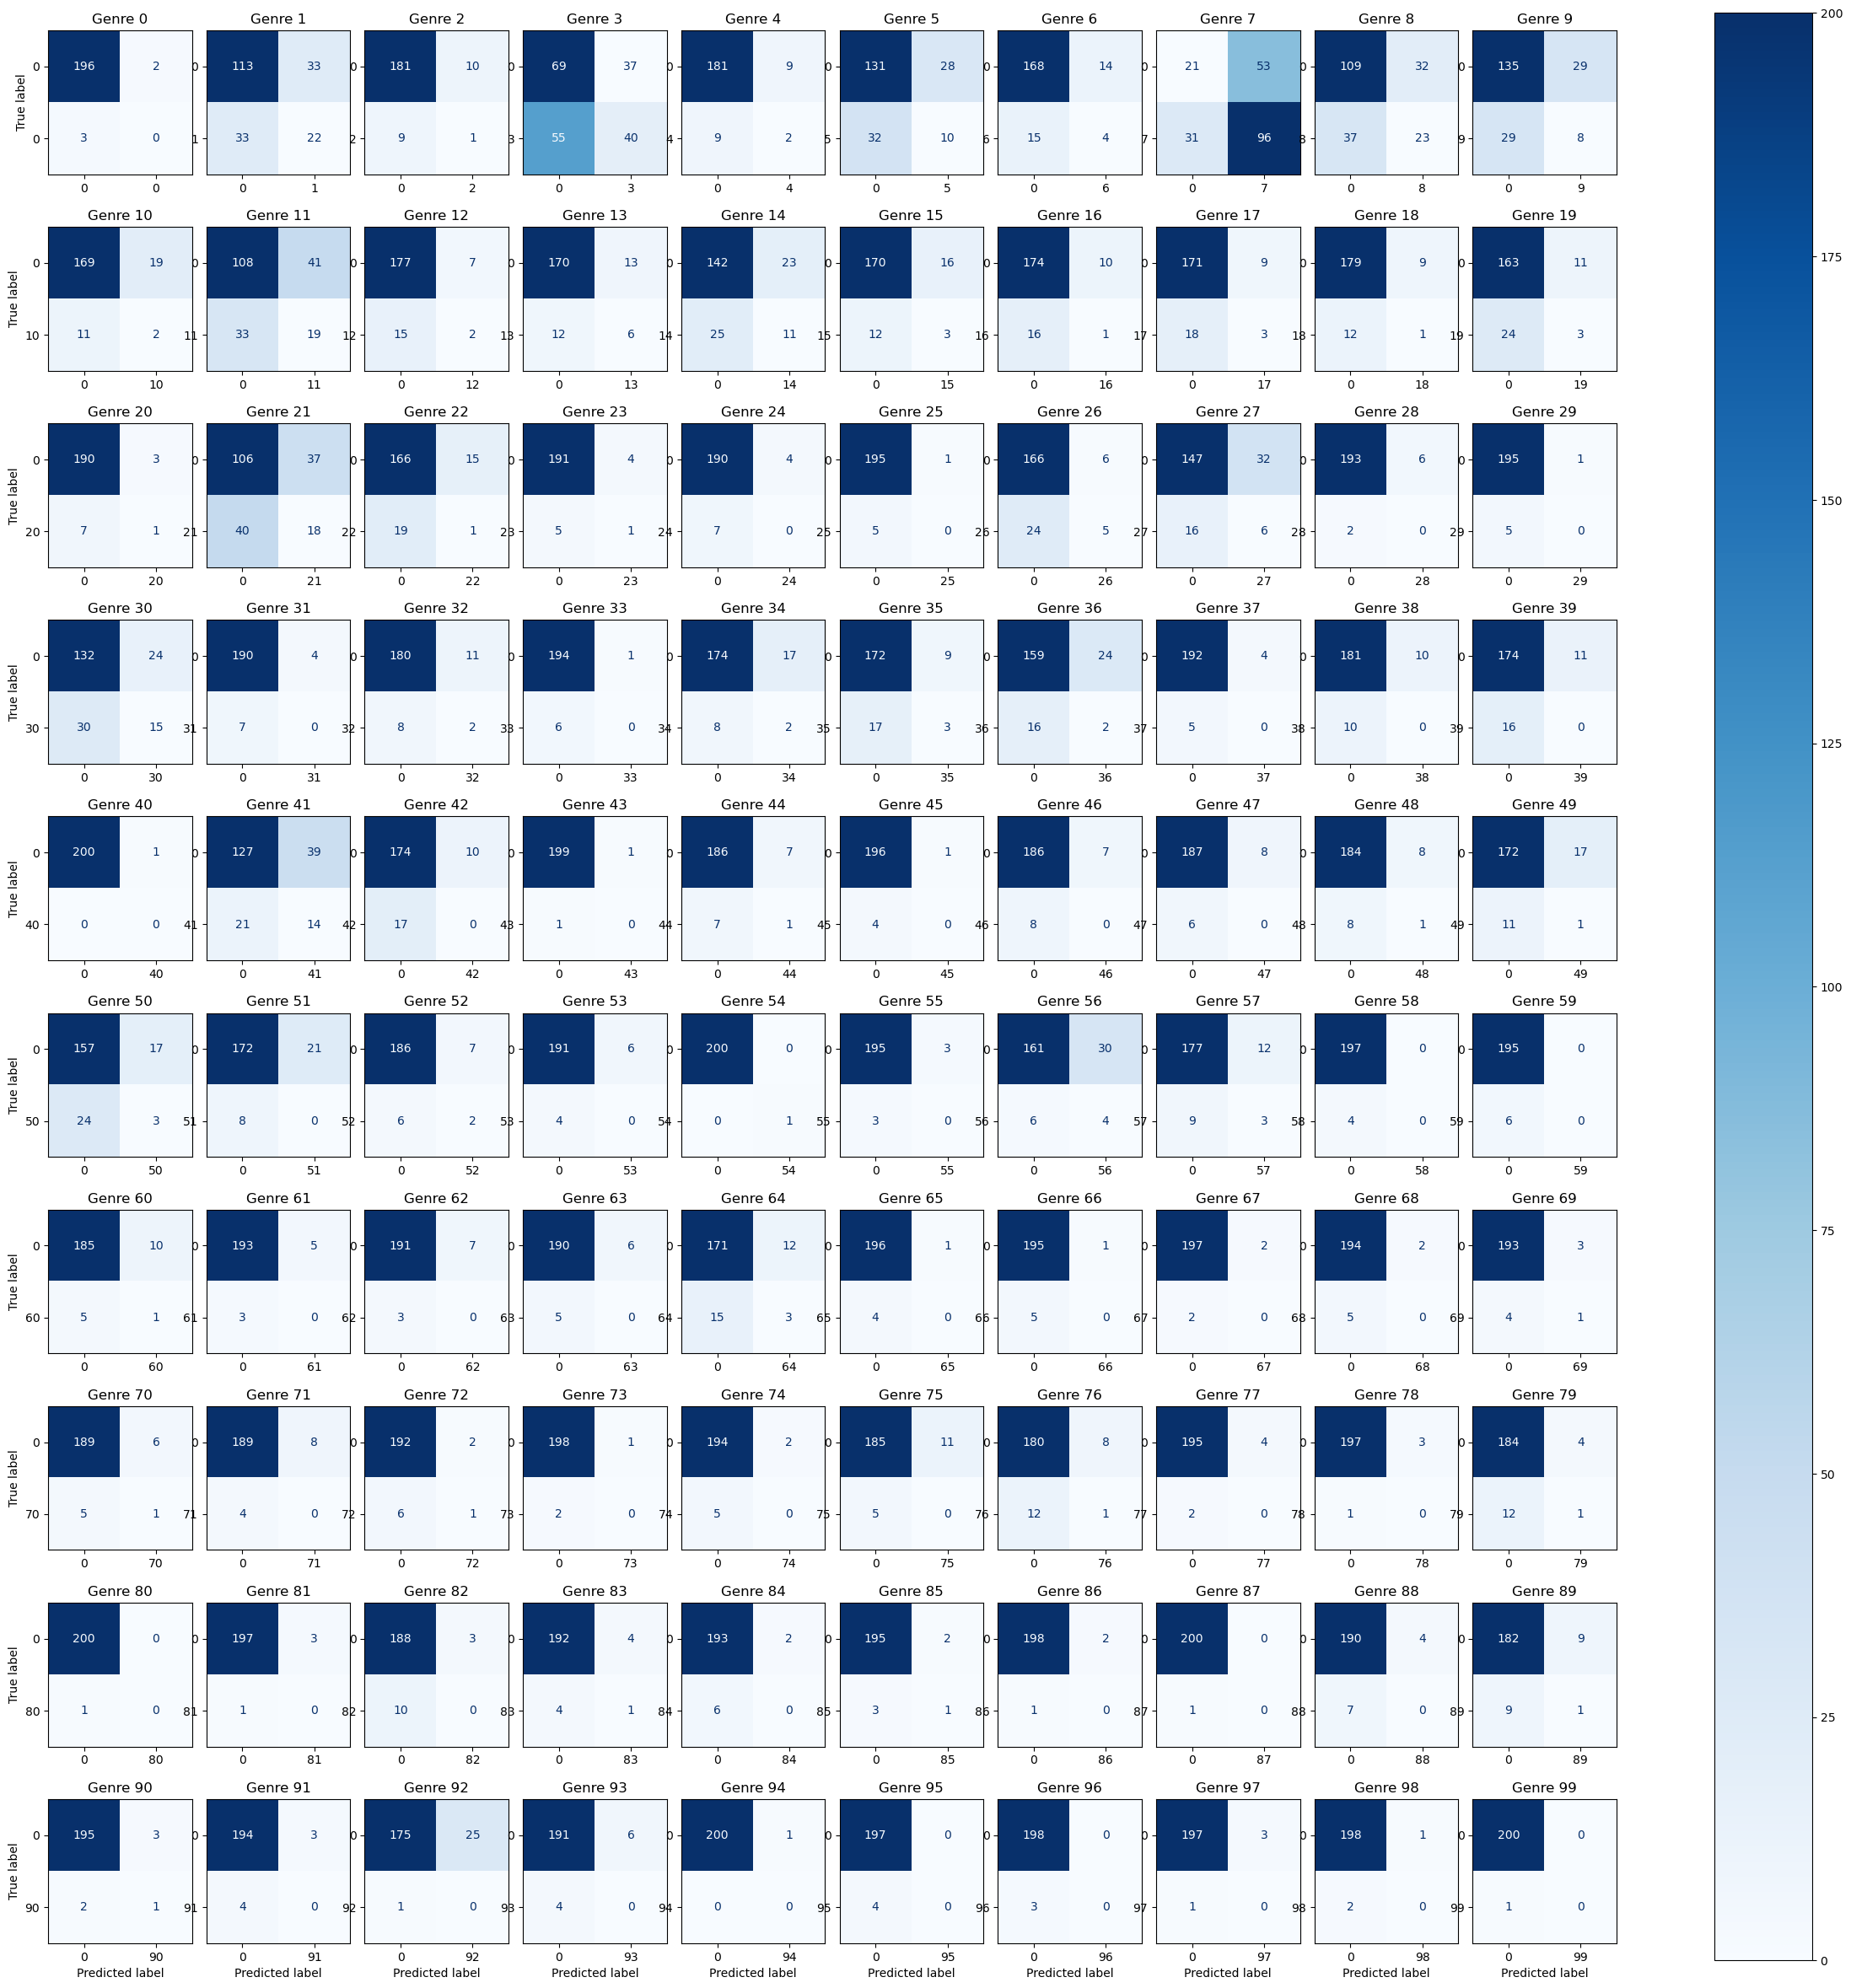

In [102]:
f, axes = plt.subplots(10, 10, figsize=(30, 30))
axes = axes.ravel()
cm=multilabel_confusion_matrix(y_test, pred_test)
for i, c in enumerate(cm):
    disp = ConfusionMatrixDisplay(c, display_labels=[0, i])
    disp.plot(cmap=plt.cm.Blues, ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'Genre {i}')
    if i<90:
        disp.ax_.set_xlabel('')
    if i%10!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()